In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ipypb import irange
%matplotlib inline

In [2]:
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print((major_ver, minor_ver, subminor_ver) )

('4', '1', '1')


In [68]:
# cap = cv2.VideoCapture('bohemian_rhapsody_live_aid.mp4')
# cap = cv2.VideoCapture('240pxqueen.mp4')
cap = cv2.VideoCapture('queen144px.mp4')
cap = cv2.VideoCapture('144continuous1.mp4')

In [69]:
total_frames = cap.get(7)

In [70]:
total_frames

2790.0

In [71]:
fps = cap.get(cv2.CAP_PROP_FPS)
print(fps)

30.0


In [72]:
total_frames/60

46.5

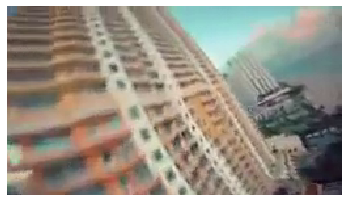

In [73]:
cap.set(1, 1000)
ret, frame = cap.read()

RGB_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(RGB_frame)
plt.show()

In [74]:
frame.shape

(144, 256, 3)

In [75]:
def show_2_figs(index1, index2, figsize=20):
    fig = plt.figure(figsize=(figsize, figsize))
    ax1 = fig.add_subplot(2,2,1)
    
    cap.set(1, index2)
    _, frame1 = cap.read()
    cap.set(1, index1)
    _, frame2 = cap.read()
    
    RGB_frame = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
    RGB_past_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
    
    ax1.imshow(RGB_past_frame)
    ax1.axis('off')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(RGB_frame)
    ax2.axis('off')
    
    plt.show()

# Histogram and Bic Functions
___

In [76]:
import math

def diff_color(img, i, j, m, n):
    return (int(np.linalg.norm(img[i][j] - img[m][n])) > 0)

In [77]:


def calc_global_histogram(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    npixels = lines * cols * channels
    
    max_size = 256
    histogram_red = np.zeros(max_size)
    histogram_green = np.zeros(max_size)
    histogram_blue = np.zeros(max_size)
    
    for i in range(0, lines):
        for j in range(0, cols):
            blue = img[i][j][0]
            red = img[i][j][2]
            green = img[i][j][1]

            histogram_blue[blue] += 1
            histogram_red[red] += 1
            histogram_green[green] += 1
    
    histogram_total = list(histogram_red) + list(histogram_green) + list(histogram_blue)
      
    return np.array(histogram_total) / npixels

In [78]:
def calc_local_histogram(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    max_size = 256
    grid = 5
    npixels = (lines // grid) * (cols // grid) * channels
    
    locals_hist = []
    
    for m in range(0, grid):
        locals_hist.append([])
        for n in range(0, grid):
            locals_hist[m].append([])
            locals_hist[m][n].append(np.zeros(max_size))
            locals_hist[m][n].append(np.zeros(max_size))
            locals_hist[m][n].append(np.zeros(max_size))

    for m in range(0, grid):
        for n in range(0, grid):
            for i in range((lines // grid) * m, (lines // grid) * (m + 1)):
                for j in range((cols // grid) * n, (cols // grid) * (n + 1)):
                    blue = img[i][j][0]
                    red = img[i][j][2]
                    green = img[i][j][1]

                    locals_hist[m][n][0][blue] += 1
                    locals_hist[m][n][1][red] += 1
                    locals_hist[m][n][2][green] += 1
    
    histogram_total = []
    for m in range(0, grid):
        for n in range(0, grid):
            partial = np.array(list(locals_hist[m][n][0]) + list(locals_hist[m][n][1]) + list(locals_hist[m][n][2])) / npixels
            histogram_total += list(partial)
    
    return np.array(histogram_total) / (grid * grid)

In [79]:
def calc_central_histogram(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    limit = 0.2
    npixels = int((lines * (1 - 2 * limit)) * (cols * (1 - 2 * limit)) * channels)
    
    max_size = 256
    histogram_red = np.zeros(max_size)
    histogram_green = np.zeros(max_size)
    histogram_blue = np.zeros(max_size)
    
    for i in range(int(limit * lines), int((1 - limit) * lines)):
        for j in range(int(limit * cols), int((1 - limit) * cols)):
            blue = img[i][j][0]
            red = img[i][j][2]
            green = img[i][j][1]

            histogram_blue[blue] += 1
            histogram_red[red] += 1
            histogram_green[green] += 1
    
    histogram_total = list(histogram_red) + list(histogram_green) + list(histogram_blue)
      
    return np.array(histogram_total) / npixels

In [80]:
def bic_global(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    npixels = lines * cols
    
    quantized = np.zeros((lines, cols, channels))
    segmented = np.zeros((lines, cols, channels))
    
    bins = 64
    
    histogram_border = np.zeros(bins)
    histogram_interior = np.zeros(bins)
    
    for i in range(0, lines):
        for j in range(0, cols):
            quantized[i][j] = img[i][j] // bins
            
    for i in range(1, lines - 1, 1):
        for j in range(1, cols - 1, 1):
            if(diff_color(quantized, i-1, j, i, j) or diff_color(quantized, i, j-1, i, j) or
                diff_color(quantized, i+1, j, i, j) or diff_color(quantized, i, j+1, i, j)):
                segmented[i][j] = [0, 0, 0] # Borda
            else:
                segmented[i][j] = [255, 255, 255] # Interior

            mapped_int = int(quantized[i][j][0]) * 16 + int(quantized[i][j][1]) * 4 + int(quantized[i][j][2])

            if segmented[i][j][0] == 0: # borda
                histogram_border[mapped_int] += 1
            else: # interior
                histogram_interior[mapped_int] += 1
    histogram_total = np.concatenate((histogram_border, histogram_interior), axis=None)
    histogram_total /= npixels
    return histogram_total

In [81]:
def bic_central(img):
    lines = img.shape[0]
    cols = img.shape[1]
    channels = img.shape[2]
    
    limit = 0.2
    central_cols = int(cols * (1 - 2 * limit))
    central_lines = int(lines * (1 - 2 * limit))
    npixels = int(central_lines * central_cols)
    
    quantized = np.zeros((lines, cols, channels))
    segmented = np.zeros((lines, cols, channels))
    
    bins = 64
    
    histogram_border = np.zeros(bins)
    histogram_interior = np.zeros(bins)
    
    for i in range(int(limit * lines), int((1 - limit) * lines)):
        for j in range(int(limit * cols), int((1 - limit) * cols)):
            quantized[i][j] = img[i][j] // bins
            
    for i in range(int(limit * lines) + 1, int((1 - limit) * lines) - 1):
        for j in range(int(limit * cols) + 1, int((1 - limit) * cols) - 1):
            if(diff_color(quantized, i-1, j, i, j) or diff_color(quantized, i, j-1, i, j) or
                diff_color(quantized, i+1, j, i, j) or diff_color(quantized, i, j+1, i, j)):
                segmented[i][j] = [0, 0, 0] # Borda
            else:
                segmented[i][j] = [255, 255, 255] # Interior

            mapped_int = int(quantized[i][j][0]) * 16 + int(quantized[i][j][1]) * 4 + int(quantized[i][j][2])

            if segmented[i][j][0] == 0: # borda
                histogram_border[mapped_int] += 1
            else: # interior
                histogram_interior[mapped_int] += 1
    histogram_total = np.concatenate((histogram_border, histogram_interior), axis=None)
    histogram_total /= npixels
    return histogram_total

In [82]:
w = 30

frames_global_hist = {}
frames_local_hist = {}
frames_global_bic = {}
frames_central_hist = {}
frames_central_bic = {}

global_hist_diff = []
local_hist_diff = []
central_hist_diff = []
global_bic_diff = []
central_bic_diff = []

for i in irange(w + 1, int(total_frames), 2 * w + 1):
    past_index = i - 2 * w + 1
    if past_index > 0:
        cap.set(1, i)
        _, frame = cap.read()
        cap.set(1, past_index)
        _, past_frame = cap.read()

        width, height, channels = frame.shape
        npixels = width * height * channels

        if past_index not in frames_global_hist.keys():
            frames_global_hist[past_index] = np.array(calc_global_histogram(past_frame))
        if i not in frames_global_hist.keys():
            frames_global_hist[i] = np.array(calc_global_histogram(frame))

        if past_index not in frames_local_hist.keys():
            frames_local_hist[past_index] = np.array(calc_local_histogram(past_frame)) 
        if i not in frames_local_hist.keys():
            frames_local_hist[i] = np.array(calc_local_histogram(frame))
        
        if past_index not in frames_global_bic.keys():
            frames_global_bic[past_index] = np.array(bic_global(past_frame)) 
        if i not in frames_global_bic.keys():
            frames_global_bic[i] = np.array(bic_global(frame))
            
        if past_index not in frames_central_hist.keys():
            frames_central_hist[past_index] = np.array(calc_central_histogram(past_frame)) 
        if i not in frames_central_hist.keys():
            frames_central_hist[i] = np.array(calc_central_histogram(frame))
            
        if past_index not in frames_central_bic.keys():
            frames_central_bic[past_index] = np.array(bic_central(past_frame)) 
        if i not in frames_central_bic.keys():
            frames_central_bic[i] = np.array(bic_central(frame))

        diff_global_hist = np.absolute(frames_global_hist[past_index] - frames_global_hist[i]).sum() / 2
        diff_local_hist = np.absolute(frames_local_hist[past_index] - frames_local_hist[i]).sum() / 2
        diff_global_bic = np.absolute(frames_global_bic[past_index] - frames_global_bic[i]).sum() / 2
        diff_central_hist =  np.absolute(frames_central_hist[past_index] - frames_central_hist[i]).sum() / 2
        diff_central_bic =  np.absolute(frames_central_bic[past_index] - frames_central_bic[i]).sum() / 2

        global_hist_diff.append({
            "diff": diff_global_hist,
            "past_index": past_index,
            "actual_index": i,
        })

        local_hist_diff.append({
            "diff": diff_local_hist,
            "past_index": past_index,
            "actual_index": i,
        })
        
        global_bic_diff.append({
            "diff": diff_global_bic,
            "past_index": past_index,
            "actual_index": i,
        })
    
        central_hist_diff.append({
            "diff": diff_central_hist,
            "past_index": past_index,
            "actual_index": i,
        })
        
        central_bic_diff.append({
            "diff": diff_central_bic,
            "past_index": past_index,
            "actual_index": i,
        })

 [████████████████████████████████████████████████████████████] 46/46 [01:56<00:03, 2.53s/it]

# Global histogram
___

In [83]:
np.array([x['diff'] for x in global_hist_diff])

array([0.38439489, 0.44269025, 0.4653682 , 0.22624602, 0.10767506,
       0.18673141, 0.35982711, 0.29739041, 0.36359773, 0.60649052,
       0.49954789, 0.18173105, 0.21183268, 0.14188187, 0.23066768,
       0.31193938, 0.12673611, 0.37402344, 0.31941732, 0.41629593,
       0.42493128, 0.20342339, 0.40454102, 0.20363137, 0.28115054,
       0.25467484, 0.24264865, 0.17804181, 0.33215784, 0.26077836,
       0.34144423, 0.19028501, 0.3948206 , 0.48161712, 0.42531105,
       0.37494575, 0.39124891, 0.40955946, 0.56769025, 0.39510995,
       0.33297164, 0.4767976 , 0.35347946, 0.34037724, 0.38745117])

In [84]:
np.array([x['diff'] for x in global_hist_diff]).mean()

0.3311905221193416

In [100]:
result = []

for element in global_hist_diff:
    if element["diff"] > 0.4:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

12


# Local histogram grid 5x5
___

In [86]:
np.array([x['diff'] for x in local_hist_diff])

array([0.73809524, 0.77151261, 0.73222222, 0.53519141, 0.28661064,
       0.7542577 , 0.73157796, 0.71637722, 0.75028011, 0.803324  ,
       0.76717087, 0.59773109, 0.62227824, 0.39432306, 0.67934641,
       0.68528478, 0.47860878, 0.6842577 , 0.71837535, 0.73311858,
       0.686676  , 0.59142857, 0.85315593, 0.50741363, 0.68985061,
       0.63776844, 0.64266106, 0.68893557, 0.67731092, 0.61788049,
       0.72724556, 0.56573296, 0.70426704, 0.69941176, 0.75219421,
       0.75861811, 0.76901961, 0.87160598, 0.89048553, 0.70023343,
       0.58867414, 0.77894491, 0.76923436, 0.67315593, 0.68525677])

In [87]:
np.array([x['diff'] for x in local_hist_diff]).mean()

0.6823801224193381

In [104]:
result = []

for element in local_hist_diff:
    if element["diff"] > 0.75:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

13


# Local histogram grid - central partition
___

In [89]:
np.array([x['diff'] for x in central_hist_diff])

array([0.62163113, 0.49614448, 0.5467812 , 0.20581217, 0.13591038,
       0.33614648, 0.39657901, 0.41858187, 0.38002662, 0.65016452,
       0.5725768 , 0.22854344, 0.36957778, 0.19742295, 0.25177706,
       0.4644714 , 0.21822018, 0.38324165, 0.37156205, 0.45095823,
       0.49815387, 0.28658981, 0.45738829, 0.26707357, 0.31688142,
       0.25747871, 0.24429207, 0.2593374 , 0.38932007, 0.44018285,
       0.53979856, 0.26491347, 0.46457187, 0.50498581, 0.46801296,
       0.41210157, 0.44671339, 0.63079899, 0.80890664, 0.39735765,
       0.32268355, 0.36847261, 0.46150755, 0.28309849, 0.43013589])

In [90]:
np.array([x['diff'] for x in central_hist_diff]).mean()

0.3981530320916953

In [91]:
result = []

for element in central_hist_diff:
    if element["diff"] > 0.3:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

32


# BIC
___

In [92]:
np.array([x['diff'] for x in global_bic_diff])

array([0.37849935, 0.31825087, 0.49777561, 0.16609701, 0.06201172,
       0.27563477, 0.35717773, 0.36116536, 0.3699273 , 0.62760417,
       0.56735569, 0.22553168, 0.33946398, 0.12196181, 0.2464464 ,
       0.37019857, 0.22916667, 0.38072374, 0.33341471, 0.40134006,
       0.36656359, 0.16669379, 0.40782335, 0.1816135 , 0.18980577,
       0.21625434, 0.22976345, 0.15258789, 0.42518446, 0.43215603,
       0.38593207, 0.1687283 , 0.40516493, 0.4921875 , 0.488227  ,
       0.38560655, 0.29825846, 0.40622287, 0.54627821, 0.28187391,
       0.32785373, 0.52213542, 0.41186523, 0.32820638, 0.38945855])

In [93]:
np.array([x['diff'] for x in global_bic_diff]).mean()

0.33858205536265434

In [94]:
result = []

for element in global_hist_diff:
    if element["diff"] > 0.2:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

38


# BIC Central
___

In [95]:
np.array([x['diff'] for x in central_bic_diff])

array([0.58511932, 0.32041344, 0.63216294, 0.13489892, 0.10525916,
       0.39899681, 0.33508132, 0.43281654, 0.50038   , 0.66567867,
       0.67981456, 0.26440188, 0.42650859, 0.15465876, 0.19341845,
       0.48191214, 0.27960176, 0.40971272, 0.41032072, 0.47750418,
       0.29084967, 0.27792978, 0.47051224, 0.29647363, 0.3497492 ,
       0.28613771, 0.28400973, 0.27124183, 0.48518012, 0.59051528,
       0.56573947, 0.20367837, 0.44839641, 0.46701626, 0.54263566,
       0.53191974, 0.45972032, 0.65526676, 0.79305366, 0.28514972,
       0.38136495, 0.4369965 , 0.44459644, 0.26371789, 0.36684907])

In [96]:
np.array([x['diff'] for x in global_bic_diff]).mean()

0.33858205536265434

In [97]:
result = []

for element in global_hist_diff:
    if element["diff"] > 0.2:
#         print(f'Frame index: {element["actual_index"]}')
#         print(f'Diff global hist: {element["diff"]}')
#         show_2_figs(element['past_index'], element['actual_index'], 10)
        
        result.append(element)
        
print(len(result))

38
